In [2]:
# This notebook is used for developing networks for subtasks of the main one. 

In [201]:
%reload_ext autoreload
%autoreload 2

from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import dominoesGameplay as dg
import dominoesAgents as da
import dominoesNetworks as dn
import dominoesFunctions as df
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Sub Task 1: Train a network to predict self-hand value and other hand value based on the tokens in the hand

In [320]:
class handValueNetwork(nn.Module):
    """
    Single layer model...
    """
    def __init__(self,highestDominoe, actFunc=F.relu, withBias=True):
        super().__init__()
        self.highestDominoe = highestDominoe
        self.dominoes = df.listDominoes(highestDominoe)
        self.numDominoes = len(self.dominoes)
        
        self.inputDimension = 2*numDominoes
        self.outputDimension = 2
        
        # create layers (all linear fully connected)
        self.fc1 = nn.Linear(self.inputDimension, 2, bias=withBias)
        # self.fc2 = nn.Linear(2,2)
        
        # create special layers
        self.actFunc = actFunc
        
    def forward(self, x):
        return self.actFunc(self.fc1(x))
        # return self.actFunc(self.fc2(self.actFunc(self.fc1(x))))

In [321]:
# batch generation function
def generateBatch(numDominoes, dominoes, batchSize):    
    numPlayed = np.random.randint(0,numDominoes+1,batchSize)
    numInHand = np.random.randint(0,numDominoes+1-numPlayed,batchSize)
    playedIdx = [np.random.choice(numDominoes,numplay,replace=False) for numplay in numPlayed]
    inHandIdx = [np.random.choice(list(set(range(numDominoes)).difference(playidx)), numhand, replace=False)
                 for (playidx,numhand) in zip(playedIdx, numInHand)]
    played = torch.zeros((batchSize,numDominoes))
    inHand = torch.zeros((batchSize,numDominoes))
    for p,pi in zip(played, playedIdx): p[pi]=1
    for h,hi in zip(inHand, inHandIdx): h[hi]=1
    playedValue = torch.tensor([np.sum(dominoes[play==1]) for play in played])
    inHandValue = torch.tensor([np.sum(dominoes[hand==1]) for hand in inHand])
    outHandValue = np.sum(dominoes) - playedValue
    return played, inHand, playedValue, inHandValue, outHandValue


# meta parameters for dominoe setting
highestDominoe = 12
dominoes = df.listDominoes(highestDominoe)
numDominoes = len(dominoes)

# mode
learnInHand = False

# create network
net = handValueNetwork(highestDominoe, actFunc=lambda x:x, withBias=True)
net.to(device)
net.fc1.bias.data[1] = np.sum(dominoes)

# training parameters and preallocation
batchSize = 1000
numIterations = 10000
trainingLoss = torch.zeros(numIterations)
targets = torch.zeros((numIterations,batchSize,2))
outputs = torch.zeros((numIterations,batchSize,2))
lossFunction = nn.L1Loss()
optimizer = torch.optim.Adadelta(net.parameters())

for it in tqdm(range(numIterations)):
    # start by zeroing the gradients prior to the batch
    optimizer.zero_grad()
    
    # generate a batch input, process the values into inputs & targets
    played, inHand, playedValue, inHandValue, outHandValue = generateBatch(numDominoes, dominoes, batchSize)
    networkInput = torch.cat((played, inHand),dim=1).to(device)
    if learnInHand:
        networkTarget = torch.stack((playedValue, inHandValue),dim=1).to(device)
    else:
        networkTarget = torch.stack((playedValue, outHandValue),dim=1).to(device)
        
    # measure network output
    networkOutput = net(networkInput)
    
    # measure loss and update netweork
    loss = lossFunction(networkOutput, networkTarget)
    loss.backward()
    optimizer.step()
    
    # store loss
    outputs[it] = networkOutput
    targets[it] = networkTarget
    trainingLoss[it] = loss.item()
    

# measure performance
with torch.no_grad():
    performanceBatch = 1000
    played, inHand, playedValue, inHandValue, outHandValue = generateBatch(numDominoes, dominoes, performanceBatch)
    networkInput = torch.cat((played, inHand), dim=1).to(device)
    if learnInHand:
        performanceTarget = torch.stack((playedValue, inHandValue), dim=1).to(device)
    else:
        performanceTarget = torch.stack((playedValue, outHandValue), dim=1).to(device)
    performanceOutput = net(networkInput)
    loss = lossFunction(performanceOutput, performanceTarget)
    performanceLoss = loss.item()
        

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:40<00:00, 10.00it/s]


tensor([2.5935e-03, 1.0920e+03], device='cuda:0')


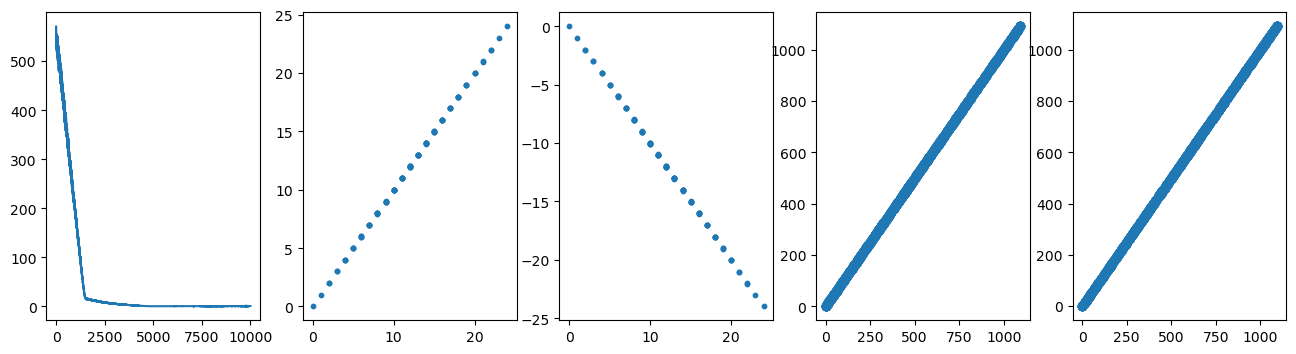

In [325]:
dominoeValue = np.sum(dominoes,axis=1)
fig,ax = plt.subplots(1,5,figsize=(16,4))
ax[0].plot(range(numIterations), trainingLoss)
ax[1].scatter(dominoeValue, net.fc1.weight.data[0][:numDominoes].clone().cpu().numpy(), s=10)
ax[2].scatter(dominoeValue, net.fc1.weight.data[1][:numDominoes].clone().cpu().numpy(), s=10)
ax[3].scatter(performanceTarget[:,0].clone().cpu().numpy(), performanceOutput[:,0].clone().cpu().numpy())
ax[4].scatter(performanceTarget[:,1].clone().cpu().numpy(), performanceOutput[:,1].clone().cpu().numpy())

print(net.fc1.bias.data)

In [323]:
performanceTarget[:5,:]

tensor([[509, 583],
        [369, 723],
        [734, 358],
        [897, 195],
        [867, 225]], device='cuda:0', dtype=torch.int32)

In [324]:
performanceOutput[:5,:]

tensor([[508.2235, 582.3704],
        [368.4686, 722.4390],
        [732.9859, 357.0762],
        [895.4476, 193.5808],
        [865.5840, 223.7439]], device='cuda:0')

In [333]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100,1)
    def forward(self,x):
        return nn.functional.relu(self.fc1(x))

In [337]:
net = network()
inp = torch.normal(0,1,(100,))
out = net(inp)
out.shape

torch.Size([1])

In [338]:
for o in out: print(o)

tensor(0., grad_fn=<UnbindBackward0>)
